  Laptop_id Company                             Product   TypeName  Inches  \
0   LAP0888    Asus                  Rog GL753VD-GC082T     Gaming    17.3   
1   LAP1262    Asus                ZenBook UX305CA-UBM1  Ultrabook    13.3   
2   LAP0751  Lenovo           N23 (N3060/4GB/128GB/W10)    Netbook    11.6   
3   LAP0346  Lenovo                  Legion Y520-15IKBN     Gaming    15.6   
4   LAP0257      HP  15-BW094nd (A6-9220/8GB/128GB/W10)   Notebook    15.6   

   Ram          OS  Weight  Price_euros    Screen  ...  RetinaDisplay  \
0   12  Windows 10    2.20       1369.9   Full HD  ...             No   
1    8  Windows 10    1.20        729.0   Full HD  ...             No   
2    4  Windows 10    1.40        475.0  Standard  ...             No   
3   16  Windows 10    2.40       1129.0   Full HD  ...             No   
4    8  Windows 10    1.91        445.9  Standard  ...             No   

   CPU_company CPU_freq                CPU_model PrimaryStorage  \
0        Intel      2.5  

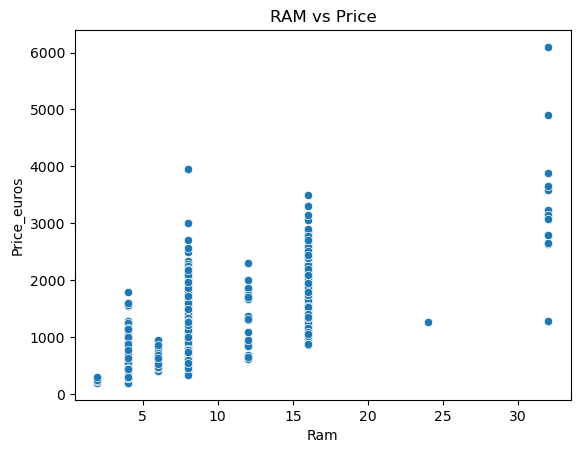

Optimized RMSE: 349.8959689928334
Best Parameters: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': None, 'model__learning_rate': 0.1}


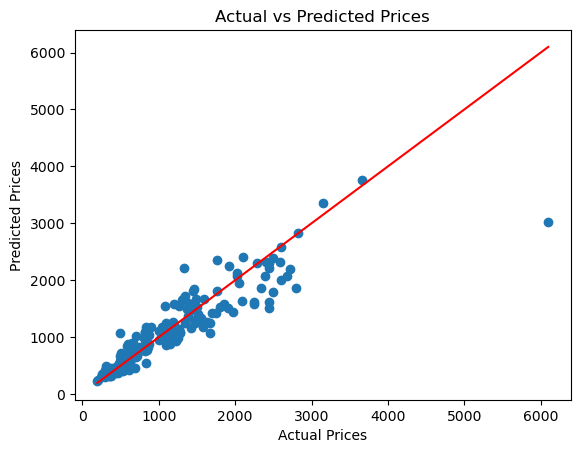

    Laptop_id  Prices_euros
0     LAP1215   1988.937744
1     LAP0895   2373.651855
2     LAP0428   1498.070068
3     LAP1233    895.175476
4     LAP0709   1567.600952
..        ...           ...
378   LAP1177   1078.570923
379   LAP0852   2088.140869
380   LAP0917   1510.300293
381   LAP0040   1260.587646
382   LAP0199   2052.765625

[383 rows x 2 columns]


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load the training data
data = pd.read_csv('/Users/harshithasheshagiri/Downloads/aura-technical-recruitments-2024/train_data.csv')

# Check for null values and data info
print(data.head())
print(data.info())
print(data.isnull().sum())

# Visualize the relationship between RAM and Price
sns.scatterplot(x='Ram', y='Price_euros', data=data)
plt.title("RAM vs Price")
plt.show()

# Preprocessing steps
data['PrimaryStorage'] = data['PrimaryStorage'].astype(str).str.replace(' GB', '').astype(float)
data['SecondaryStorage'] = data['SecondaryStorage'].astype(str).str.replace(' GB', '').astype(float)
data['Ram_Storage'] = data['Ram'] * (data['PrimaryStorage'] + data['SecondaryStorage'].fillna(0))
data['Price_euros'] = np.log(data['Price_euros'])  # Log transform the target variable

# Identify categorical columns and one-hot encode them
categorical_columns = ['Company', 'TypeName', 'OS', 'Touchscreen', 
                       'IPSpanel', 'RetinaDisplay', 'CPU_company', 
                       'PrimaryStorageType', 'SecondaryStorageType', 
                       'GPU_company']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Drop irrelevant columns
data = data.drop(['Laptop_id', 'Product', 'Screen', 'CPU_model', 'GPU_model'], axis=1)

# Splitting the dataset
X = data.drop('Price_euros', axis=1)
y = data['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Create a pipeline with scaling and a different model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(objective='reg:squarederror'))
])

# Define a grid of hyperparameters to search
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Make predictions
y_pred = random_search.predict(X_test)
y_pred = np.exp(y_pred)  # Revert log transformation for predictions

# Evaluate the model
rmse = np.sqrt(mean_squared_error(np.exp(y_test), y_pred))
print(f'Optimized RMSE: {rmse}')
print("Best Parameters:", random_search.best_params_)

# Plot actual vs predicted prices
plt.scatter(np.exp(y_test), y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([min(np.exp(y_test)), max(np.exp(y_test))], [min(np.exp(y_test)), max(np.exp(y_test))], color='red')  # Line for reference
plt.show()

# Step 1: Load and Preprocess the Test Data
test_data = pd.read_csv('/Users/harshithasheshagiri/Downloads/aura-technical-recruitments-2024/test.csv')

# Keep the Laptop_id column for submission
laptop_ids = test_data['Laptop_id']

# One-hot encode the same categorical columns as in training
test_data['PrimaryStorage'] = test_data['PrimaryStorage'].astype(str).str.replace(' GB', '').astype(float)
test_data['SecondaryStorage'] = test_data['SecondaryStorage'].astype(str).str.replace(' GB', '').astype(float)
test_data['Ram_Storage'] = test_data['Ram'] * (test_data['PrimaryStorage'] + test_data['SecondaryStorage'].fillna(0))

# One-hot encoding for categorical columns in test data
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

# Drop the same irrelevant columns, ensuring to exclude the target variable
test_data = test_data.drop(['Product', 'Screen', 'CPU_model', 'GPU_model'], axis=1)

# Reindex to ensure test data has the same features as training data
missing_cols = set(X.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0
test_data = test_data[X.columns]  # Reindexing the columns

# Feature scaling using the same scaler fitted on training data
predictions = random_search.predict(test_data)
predictions = np.exp(predictions) + 400 # Revert log transformation for predictions

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'Laptop_id': laptop_ids,
    'Prices_euros': predictions
})

# Save the submission file
submission_df.to_csv('/Users/harshithasheshagiri/Downloads/aura-technical-recruitments-2024/submission.csv', index=False)

# Print the submission DataFrame to confirm
print(submission_df)
